##### Название папок с распознанными объектами

In [1]:
filenames = ['Downloads/answer_first/{}', 
             'Downloads/answer_second/{}', 
             'Downloads/answer_third/{}',
            'answer_4/{}',
            'Downloads/answer/{}']

In [3]:
def open_and_split(filenames, class_name='pedestrian'):
    data = []
    for filename in filenames:
        data += open(filename.format(class_name)).readlines()
        
    videos = {}
    for row in data:
        splits = row[:-2].split(' ')
        if splits[0] not in videos:
            videos[splits[0]] = [[float(x) for x in splits[1:]]]
        else:
            videos[splits[0]].append([float(x) for x in splits[1:]])
    return videos

## Считавание всех распознанных объектов 

In [4]:
bicyclist = open_and_split(filenames, 'bicyclist')
bus = open_and_split(filenames, 'bus')
car = open_and_split(filenames, 'car')
cart = open_and_split(filenames, 'cart')
pedestrian = open_and_split(filenames, 'pedestrian')
skater = open_and_split(filenames, 'skater')
skateboarer = open_and_split(filenames, 'skateboarder')
biker = open_and_split(filenames, 'biker')

In [5]:
def plot_rect(class_dict, class_name, ax, name):
    """
    Добавление аннотированных детекций к объекту ax
    Args:
        ax (AxesSubplot): объект, к которому добавляются прямоугольники и аннотации
        name (str): название видео
        class_name (str): название класса
        class_dict: словарь, в котором ключ - это название видео, а значение это координаты и скор детекции класса class_name
    """
    all_data = class_dict[name]
    for data in all_data:
        x1 = data[1]
        x2 = data[2]
        x3 = data[3]
        x4 = data[4]
        score = data[0]
        if score > 0.5:
            rect = patches.Rectangle((float(x1), 
                                float(x2)),
                                float(x3)-float(x1), 
                                float(x4)-float(x2),
                                linewidth=1, edgecolor='r',facecolor='none', lw=2, label='test')


            ax.add_patch(rect)
            x, y = rect.get_xy()
            l = (x3 - x1) / 2
            ax.annotate(class_name, (x, y), color='b', weight='bold', 
                        fontsize=20, ha='center', va='center')
            ax.annotate(score, (x + l, y + 20), color='w', weight='bold', 
                        fontsize=10, ha='center', va='center')

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm

In [27]:
def save_images(video_name, images_count, jpeg_prefix='STANFORDdevkit/JPEGImages'):
    """
    Аннотация всех изображений детекциями, полученными с помощью сетки
    Args:
        video_name (str): название видео в формате "{scene}_video{N}"
        images_count (int): количество изображений в сцене
        jpeg_prefix (str): директория, где хранятся изображения
    """
    if not os.path.exists(video_name):
        os.mkdir(video_name)
    videos = os.listdir(video_name)
    for i in tqdm(range(1, images_count)):
        number = str(i)
        if '{}.png'.format(number) not in videos:
            name = '{}_{}'.format(video_name, number)
            im = np.array(Image.open('{}/{}.jpg'.format(jpeg_prefix, name)), dtype=np.uint8)
            fig,ax = plt.subplots(1, figsize=(20,30))
            if name in bus:
                plot_rect(bus, 'bus', ax, name)

            if name in bicyclist:
                plot_rect(bicyclist, 'bicyclist', ax, name)

            if name in car:
                plot_rect(car, 'car', ax, name)

            if name in cart:
                plot_rect(cart, 'cart', ax, name)

            if name in skater:
                plot_rect(skater, 'skater', ax, name)

            if name in skateboarer:
                plot_rect(skateboarer, 'skateboarder', ax, name)

            if name in pedestrian:
                plot_rect(pedestrian, 'pedestrian', ax, name)

            if name in biker:
                plot_rect(biker, 'biker', ax, name)

            ax.imshow(im)
            plt.savefig('{}/{}.png'.format(video_name, number), bbox_inches='tight')

In [28]:
prefix = 'Downloads/stanford_campus_dataset/STANFORDdevkit/JPEGImages'
video_name = 'coupa_video2'
images_count = 0

In [29]:
all_jpegs = os.listdir(prefix)
for jpeg in all_jpegs:
    if video_name in jpeg:
        images_count += 1

### Запуск функции, которая записывает аннотированные изображения:

  0%|          | 11/11965 [00:19<5:52:50,  1.77s/it]

KeyboardInterrupt: 

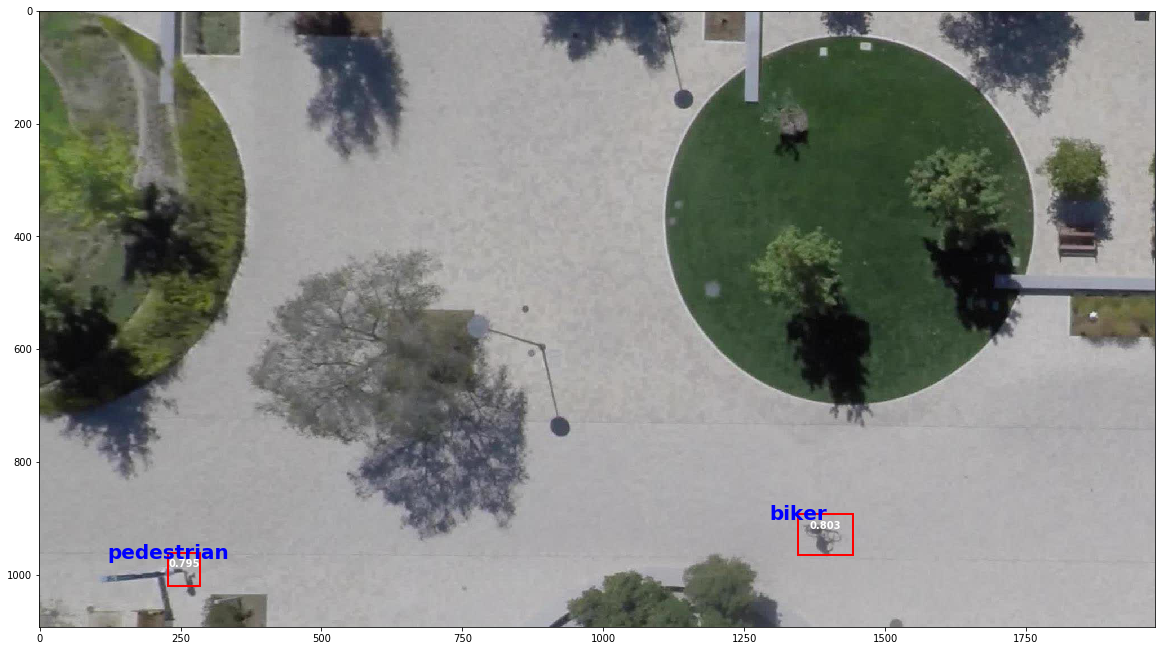

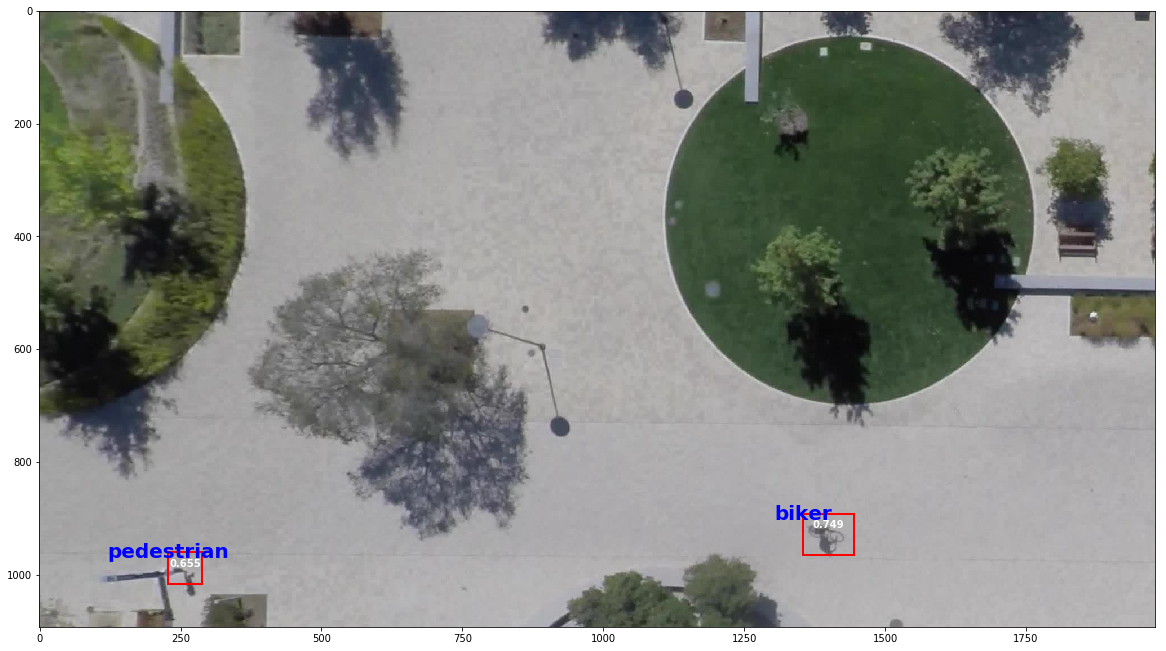

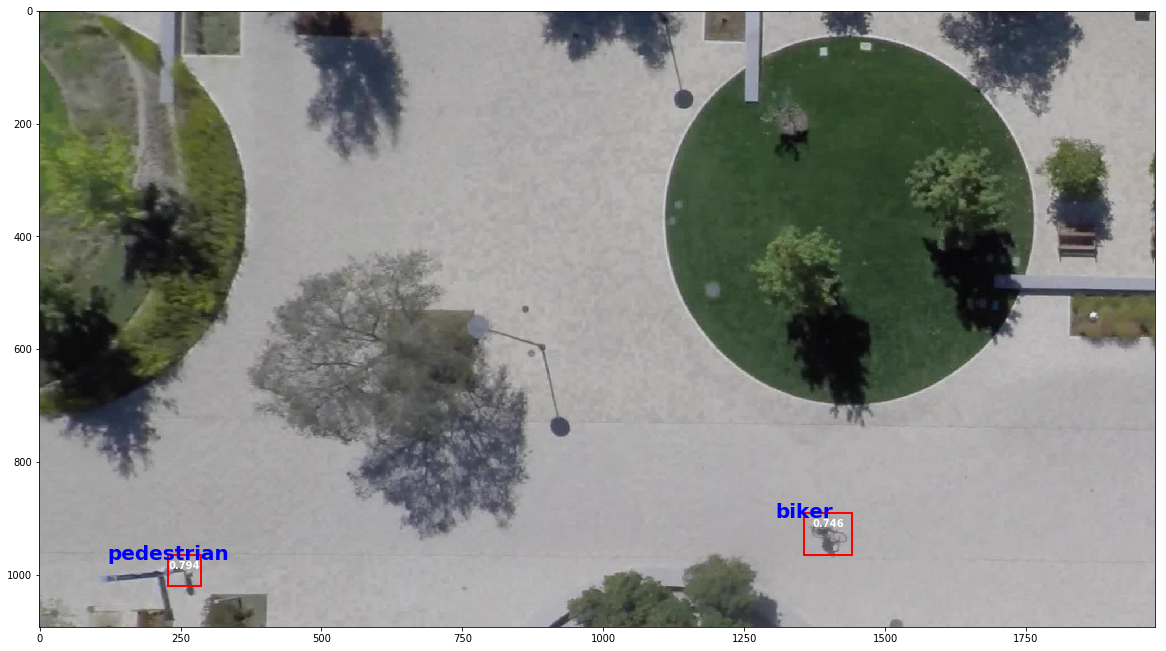

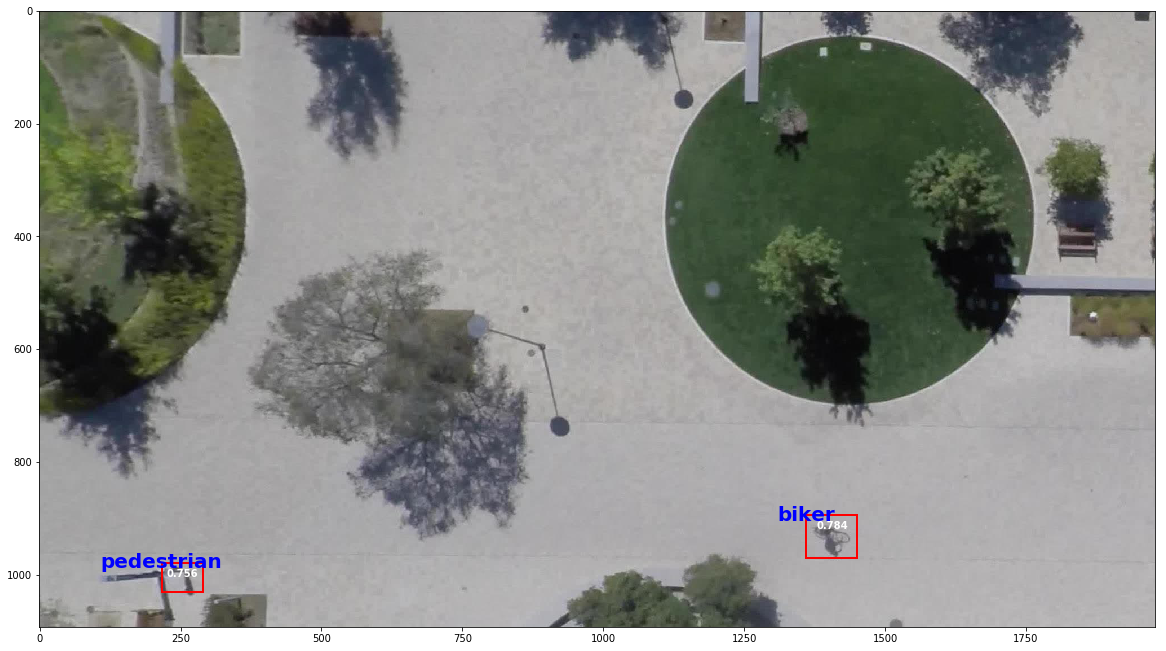

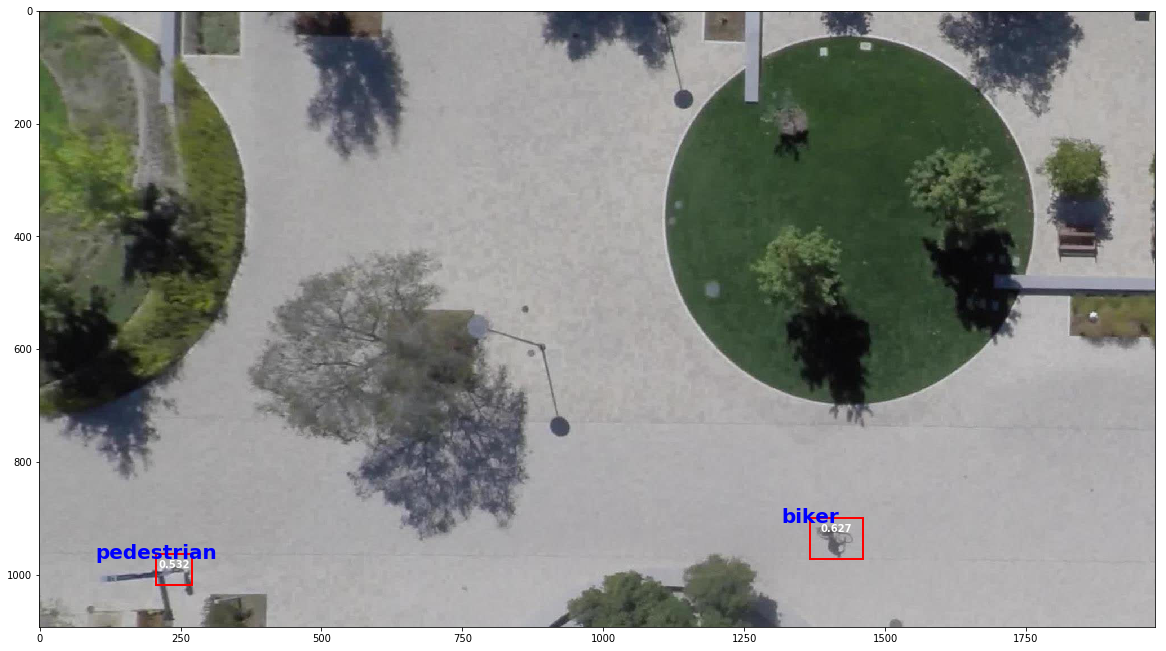

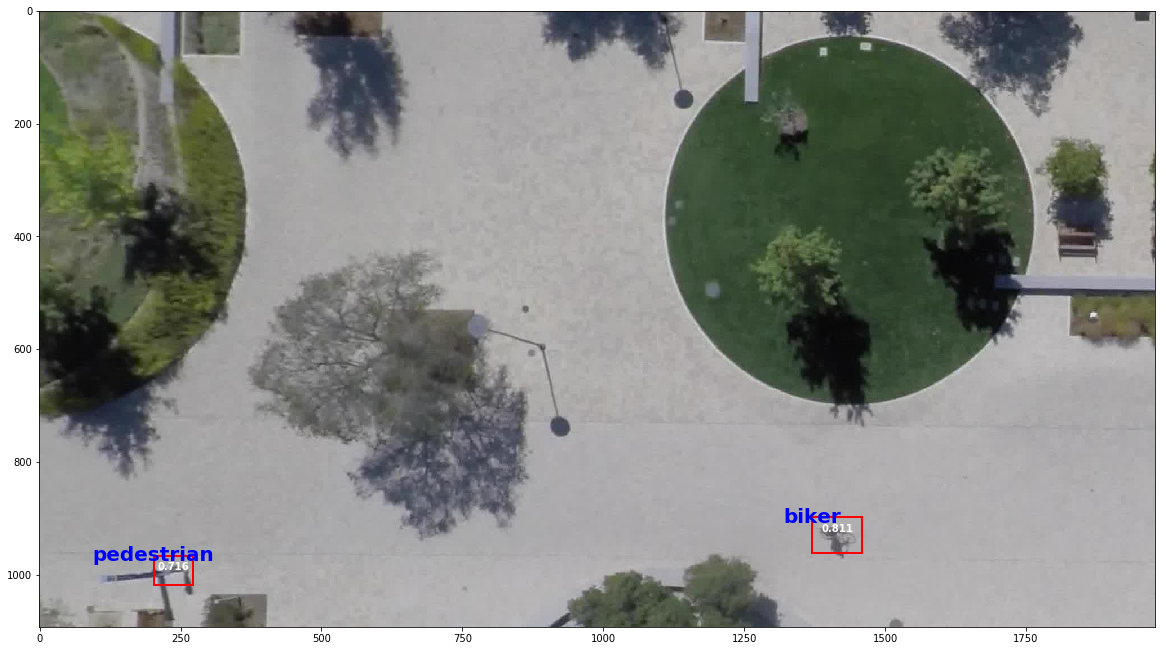

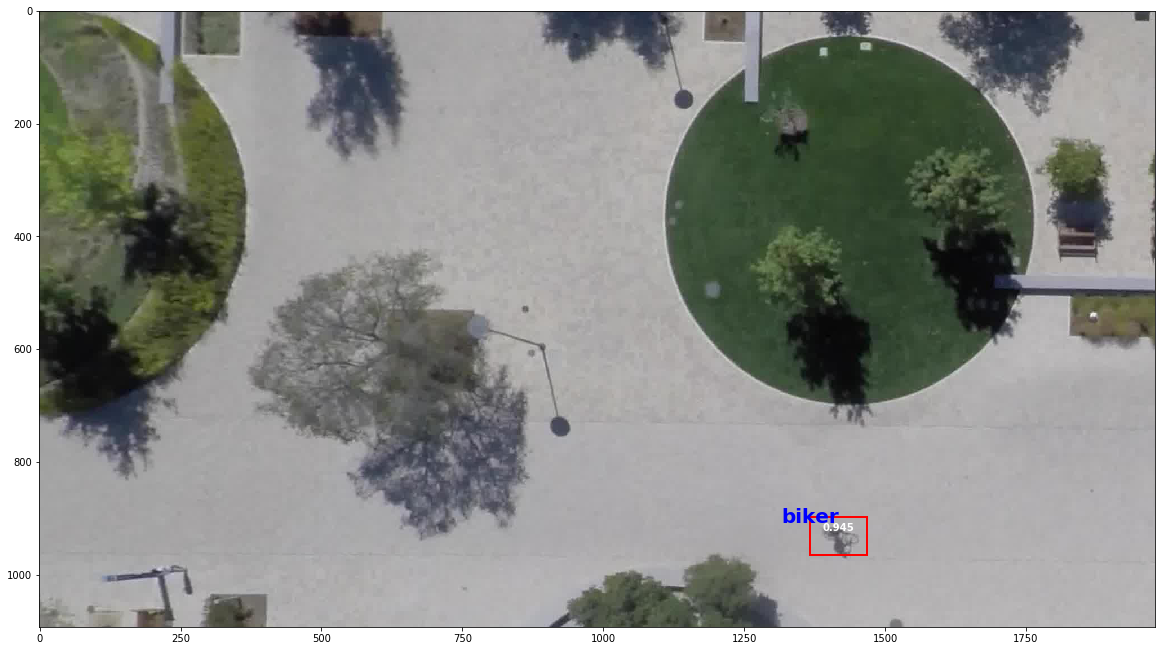

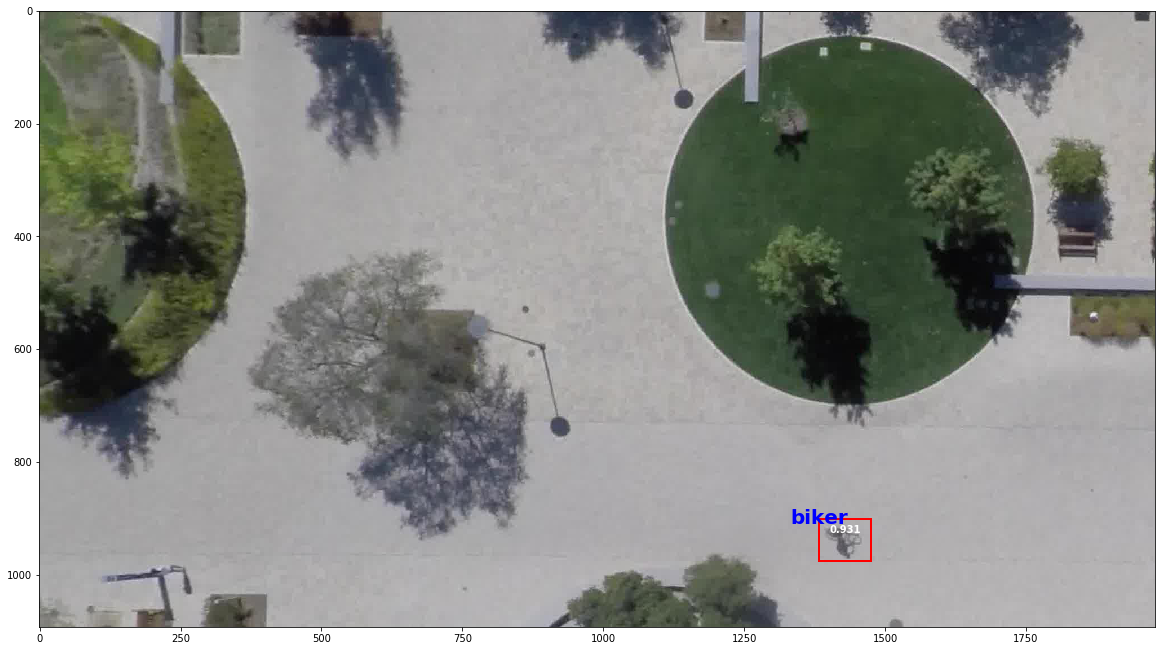

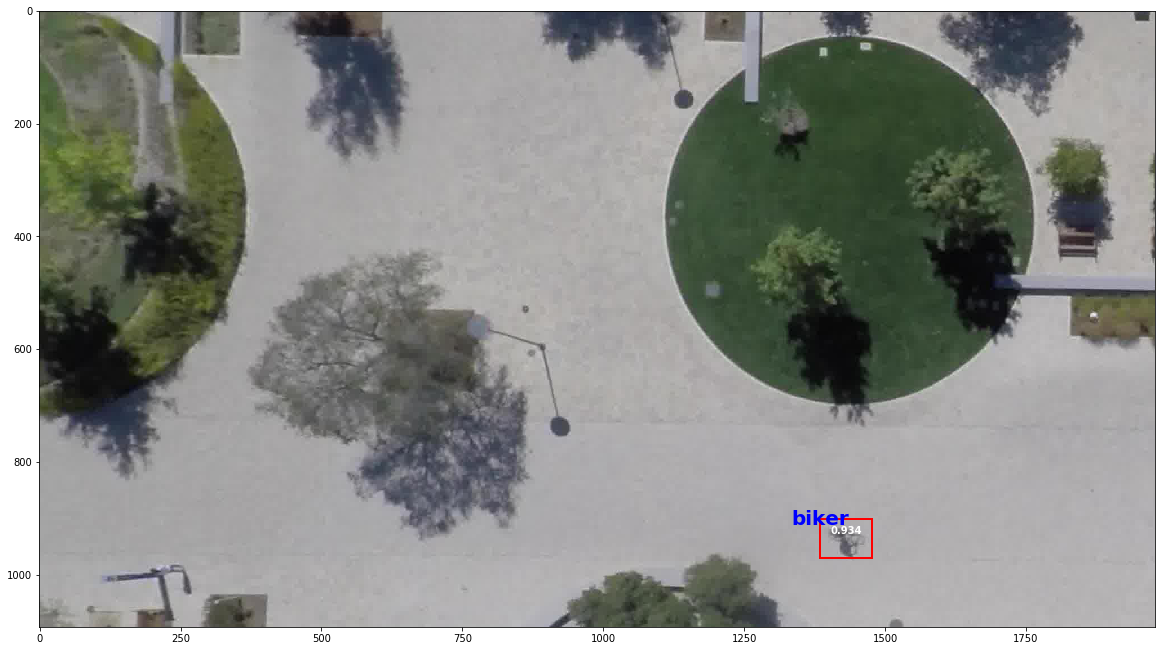

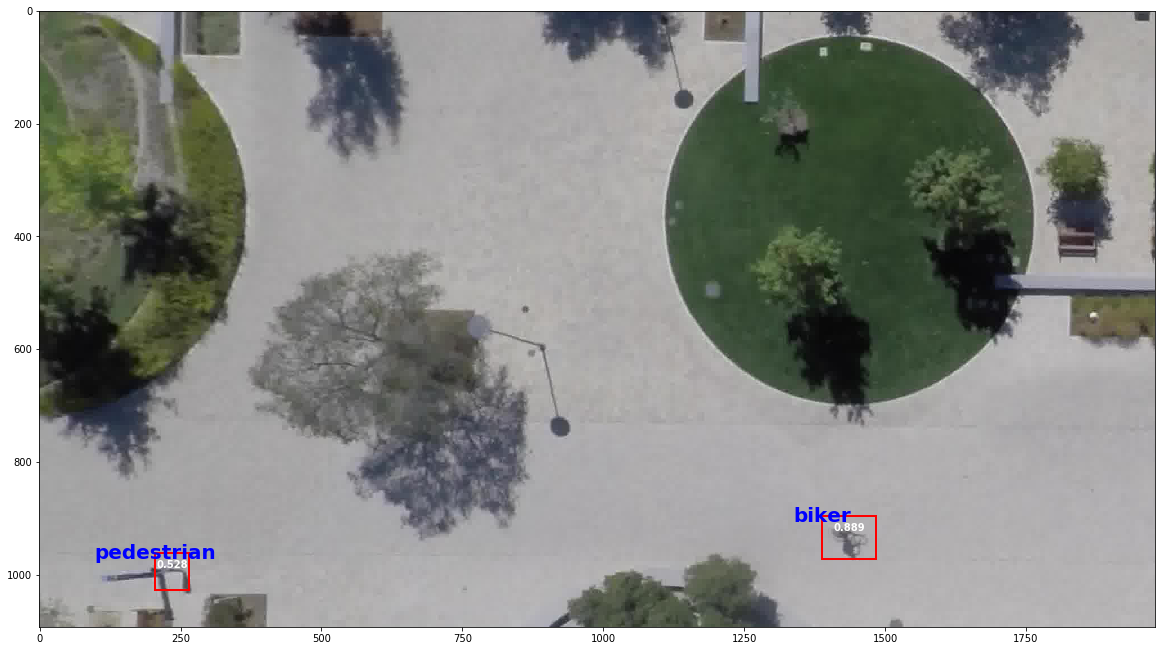

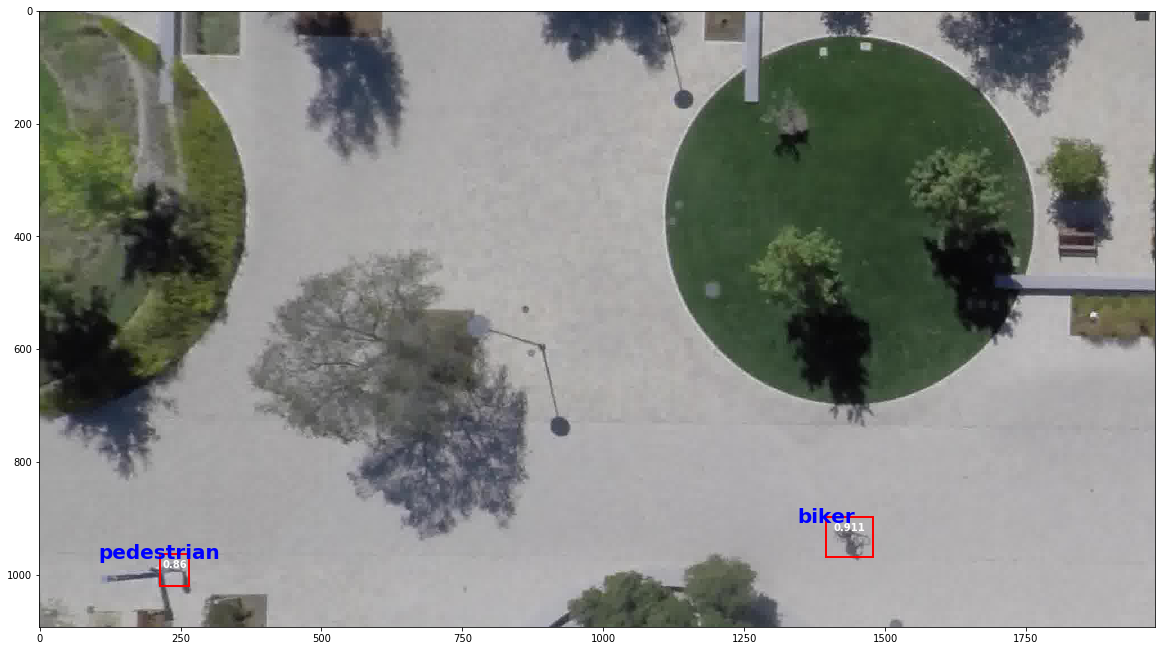

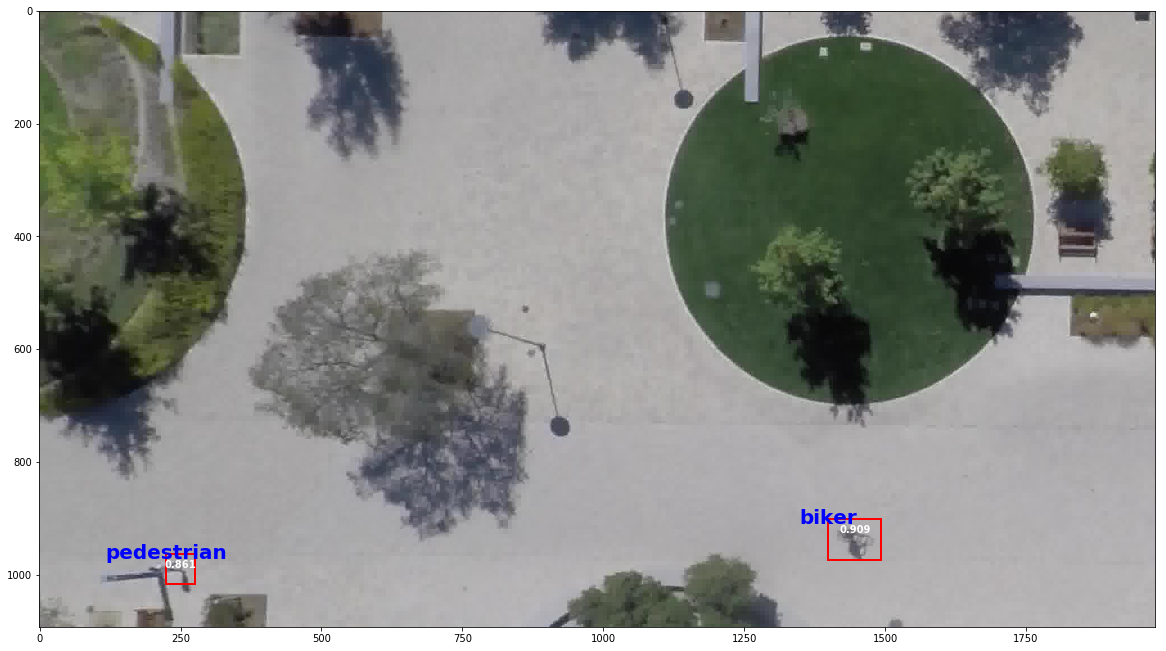

In [31]:
save_images(video_name, images_count, prefix)

## Подсчет метрик

In [33]:
def find_closest(xmin, xmax, ymin, ymax, predicted):
    """
    Нахождение ближайшей предсказанной детекции к заданным координатам xmin, xmax, ymin, ymax
    """
    best_ovr = 0
    for data in predicted:
        #if data[0] > 0.5:
        x1 = data[1]
        x2 = data[2]
        x3 = data[3]
        x4 = data[4]
        ixmin = max(x1, xmin)
        iymin = max(x2, ymin)
        ixmax = min(x3, xmax)
        iymax = min(x4, ymax)
        inter = max(ixmax - ixmin + 1, 0)*max(iymax - iymin + 1, 0)
        uni = ((x3 - x1 + 1.) * (x4 - x2 + 1.) +
               (ymax - ymin + 1.) *
               (xmax - xmin + 1.) - inter)
        ovr = inter/uni
        if ovr > best_ovr:
            best_ovr = ovr
    return best_ovr

In [34]:
def iou(xmin, ymin, xmax, ymax, data):
    """
    Подсчет iou
    Args:
        xmin (flaot): самая левая координата по х
        ymin (float): самая нижняя координата по y
        xmax (float): самая правая координата по x
        ymax (float): самая верхняя координата по y
        data (list): [score, xmin, ymin, xmax, ymax]
    """
    x1 = data[1]
    x2 = data[2]
    x3 = data[3]
    x4 = data[4]
    ixmin = max(x1, xmin)
    iymin = max(x2, ymin)
    ixmax = min(x3, xmax)
    iymax = min(x4, ymax)
    inter = max(ixmax - ixmin + 1, 0)*max(iymax - iymin + 1, 0)
    uni = ((x3 - x1 + 1.) * (x4 - x2 + 1.) +
           (ymax - ymin + 1.) *
           (xmax - xmin + 1.) - inter)
    if uni <= 0.001:
        return 0
    ovr = inter/uni
    return ovr

In [35]:
def count_images(pref, all_jpegs):
    counter = 0
    for jpeg in all_jpegs:
        if pref in jpeg:
            counter += 1
    return counter

### MOTP COUNTING

In [63]:
def motp_count(videos_dict, cl, classes, all_jpegs, ann_path):
    motp = {}
    fp = {}
    fn = {}
    counts = {}
    for scene, videos_list in videos_dict.items():
        for video in videos_list:
            temp_res = 0
            counter = 0
            pref = '{}_video{}'.format(scene, video)
            videos = count_images(pref, all_jpegs)
            pref += '_'
            fp[pref] = 0
            fn[pref] = 0
            for number in range(1, videos):
                name = pref + str(number)
                tree = ET.parse("{}/{}.xml".format(ann_path, name))
                root = tree.getroot()
                predicted = classes.get(cl, {}).get(name, [])

                if cl == 'all':
                    for class_ in classes.values:
                        predicted += class_.get(name, [])

                for country in root.findall('object'):
                    name = country.find('name').text.lower()
                    if name == cl :
                        xmin = int(country.find('bndbox').find('xmin').text)
                        xmax = int(country.find('bndbox').find('xmax').text)
                        ymin = int(country.find('bndbox').find('ymin').text)
                        ymax = int(country.find('bndbox').find('ymax').text)

                        closest = find_closest(xmin, xmax, ymin, ymax, predicted)
                        temp_res += closest
                        counter += 1
                        if closest < 0.5:
                            fn[pref] += 1

                for data in predicted:
                    if float(data[0]) > 0.5:
                        max_iou = 0
                        for country in root.findall('object'):
                            name = country.find('name').text.lower()
                            if name == cl :
                                xmin = int(country.find('bndbox').find('xmin').text)
                                xmax = int(country.find('bndbox').find('xmax').text)
                                ymin = int(country.find('bndbox').find('ymin').text)
                                ymax = int(country.find('bndbox').find('ymax').text)
                                cur_iou = iou(xmin, ymin, xmax, ymax, data)
                                if cur_iou > 0.5:
                                    max_iou = cur_iou
                                    break
                        if max_iou < 0.5:
                            fp[pref] += 1


            if counter > 0:
                motp[pref] = temp_res / counter
            counts[pref] = counter
            
    return counts, motp, fp, fn

In [76]:
def find_neigbour(data, name, classes):
    predicted = []
    for class_ in classes.values():
        predicted += class_.get(name, [])
        
    max_iou = 0
    xmin, ymin, xmax, ymax = 0, 0, 0, 0
    for data2 in predicted:
        cur_iou = iou(data2[1], data2[2], data2[3], data2[4], data)
        if cur_iou > max_iou:
            max_iou = cur_iou
            xmin, ymin, xmax, ymax = data2[1], data2[2], data2[3], data2[4]
    return max_iou, xmin, ymin, xmax, ymax

In [69]:
def split_annotation(annotation):
    an_dict = {}
    for an in annotation:
        an_ = an.split(' ')
        number = int(an_[5])
        if number in an_dict:
            an_dict[number].append(an)
        else:
            an_dict[number] = [an]
    return an_dict

In [47]:
classes = {
    'bus': bus,
    'biker': biker,
    'bicyclist': bicyclist,
    'pedestrian': pedestrian,
    'cart': cart,
    'car': car,
    'skater': skater,
    'skateboarder': skateboarer
}

In [48]:
all_jpegs = os.listdir('Downloads/stanford_campus_dataset/STANFORDdevkit/JPEGImages/')
all_jpegs = [jpeg[:-4] for jpeg in all_jpegs]
cl = 'pedestrian'

In [49]:
ann_path = 'Downloads/stanford_campus_dataset/STANFORDdevkit/Annotations'

In [50]:
videos_dict = {
    'bookstore': [6],
    'coupa': [3],
}

In [65]:
motp_count(videos_dict, 'pedestrian', classes, all_jpegs, ann_path)

({'bookstore_video6_': 49829, 'coupa_video3_': 156589},
 {'bookstore_video6_': 0.47077820910206886,
  'coupa_video3_': 0.4286049353731345},
 {'bookstore_video6_': 62409, 'coupa_video3_': 59813},
 {'bookstore_video6_': 26492, 'coupa_video3_': 108965})

In [73]:
def id_sw_count(videos_dict, cl, classes, all_jpegs, ann_path):
    id_sw = {}
    for scene, videos_list in videos_dict.items():
        for video in videos_list:
            annotation = open('{}/{}/video{}/annotations.txt'.format(ann_path, scene, video)).readlines()
            an_dict = split_annotation(annotation)
            pref = '{}_video{}'.format(scene, video)
            videos = count_images(pref, all_jpegs)
            pref += '_'
            id_sw[pref] = 0

            for number in range(1, videos-1):
                name = pref + str(number)
                predicted = classes.get(cl, {}).get(name, [])

                if cl == 'all':
                    for class_ in classes.values:
                        predicted += class_.get(name, [])

                for data in predicted:
                    if data[0] > 0.5:
                        neig = find_neigbour(data, pref + str(number+1), classes)
                        best_iou = 0
                        tr_id = 0
                        ans_n = an_dict[number]
                        for ans in ans_n:
                            an = ans.split(' ')
                            xmin = int(an[1])
                            ymin = int(an[2])
                            xmax = int(an[3])
                            ymax = int(an[4])
                            temp_iou = iou(xmin, ymin, xmax, ymax, data)
                            if temp_iou > best_iou:
                                best_iou = temp_iou
                                tr_id = int(an[0])

                        xmin, ymin, xmax, ymax = -1, -1, -1, -1
                        if best_iou > 0.5:
                            ans_n = an_dict[number + 1]
                            for ans in ans_n:
                                an = ans.split(' ')
                                if int(an[0]) == tr_id:
                                    xmin, ymin, xmax, ymax = int(an[1]), int(an[2]), int(an[3]), int(an[4])
                                    break
                            if xmin > -1:
                                if neig[0] < 0.7:
                                    id_sw[pref] += 1
                                else:
                                    temp_iou = iou(xmin, ymin, xmax, ymax, neig)
                                    if temp_iou < 0.5:
                                        id_sw[pref] += 1
    return id_sw

In [71]:
ann_path2 = 'Downloads/stanford_campus_dataset-2/annotations'

In [77]:
id_sw_count(videos_dict, 'pedestrian', classes, all_jpegs, ann_path2)

{'bookstore_video6_': 3132, 'coupa_video3_': 7680}